In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import keras
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from keras.models import Model
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
IMG_SIZE = 299
class_map = {'fullOK':0, 'fullNG': 1}

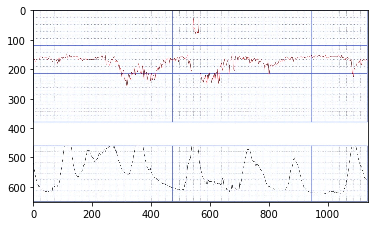

In [4]:
# Read single image

data_path = '/content/drive/My Drive/Colab Notebooks/tjp_HC_models/tjp_imgs for model training(195imgs)/*/*.jpg' 
img_paths = glob(data_path)
img = cv2.imread(img_paths[0])
plt.imshow(img)

((651, 1137, 3), (299, 299, 3))

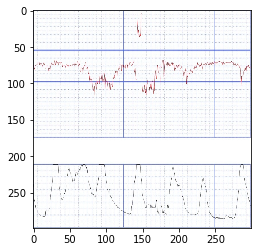

In [5]:
# Resize img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [6]:
# Extract img class
img_path = img_paths[0]
img_path

'/content/drive/My Drive/Colab Notebooks/tjp_HC_models/tjp_imgs for model training(195imgs)/fullNG/NG_demo02181full_60235067-6.jpg'

In [7]:
cls = img_path.split('/')[-2]
cls

'fullNG'

In [8]:
class_map[cls]

1

In [0]:
data_count = len(img_paths)
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

In [10]:
for i, path in tqdm(enumerate(sorted(img_paths))):
    img = cv2.imread(path)
    img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    cls = path.split('/')[-2]
    
    X[i] = img_resize
    y[i] = class_map[cls]

In [11]:
# label count
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0.0: 195, 1.0: 196}

In [0]:
from keras.applications.inception_v3 import preprocess_input
X = preprocess_input(X)
y_onehot = keras.utils.to_categorical(y, num_classes=2)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.15, random_state=5566)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((332, 299, 299, 3), (59, 299, 299, 3), (332, 2), (59, 2))

In [14]:
# 1
base_model = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(base_model.input, predictions)

In [15]:
from keras.utils import plot_model
plot_model(model, show_shapes=True,) 

Output hidden; open in https://colab.research.google.com to view.

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [17]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [0]:
file_path = '/content/drive/My Drive/Colab Notebooks/tjp_HC_models/tjp_output collection/'

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

checkpoint = ModelCheckpoint(file_path +'HC-IncepV3-1-val_loss{val_loss:.3f}-val_acc{val_acc:.2f}.h5',
    monitor='val_loss', save_weights_only=False, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-9)

In [19]:
logs = model.fit(X_train, y_train,
                batch_size=20,
                epochs=100,
                verbose=2,
                callbacks=[early_stopping, reduce_lr, checkpoint],     
                validation_data=(X_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 332 samples, validate on 59 samples
Epoch 1/100
 - 22s - loss: 0.7936 - acc: 0.7289 - val_loss: 0.4046 - val_acc: 0.8475
Epoch 2/100
 - 4s - loss: 0.2466 - acc: 0.8976 - val_loss: 0.4139 - val_acc: 0.9153
Epoch 3/100
 - 4s - loss: 0.0468 - acc: 0.9940 - val_loss: 0.3635 - val_acc: 0.9322
Epoch 4/100
 - 4s - loss: 0.2246 - acc: 0.9217 - val_loss: 1.0935 - val_acc: 0.4407
Epoch 5/100
 - 4s - loss: 0.0936 - acc: 0.9639 - val_loss: 4.2698 - val_acc: 0.5593
Epoch 6/100
 - 4s - loss: 0.1401 - acc: 0.9548 - val_loss: 0.7134 - val_acc: 0.8475

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/100
 - 4s - loss: 0.0982 - acc: 0.9608 - val_loss: 0.2375 - val_acc: 0.9492
Epoch 8/100
 - 4s - loss: 0.0448 - acc: 0.9789 - val_loss: 0.2625 - val_acc: 0.9492
Epoch 9/100
 - 4s - loss: 0.0260 - acc: 0.9940 - val_loss: 0.0910 - val_acc: 0.9661
Epoch 10/100
 - 4s -

In [0]:
history = logs.history

Text(0.5, 1.0, 'acc')

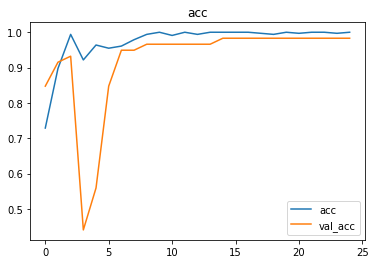

In [21]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

Text(0.5, 1.0, 'loss')

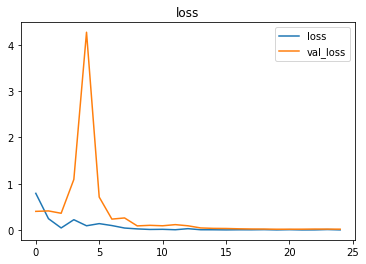

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_true.shape, y_pred.shape)
target_names = [str(i) for i in range(2)]
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))

(59,) (59,)
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.97      1.00      0.98        28

    accuracy                           0.98        59
   macro avg       0.98      0.98      0.98        59
weighted avg       0.98      0.98      0.98        59

[[30  1]
 [ 0 28]]


In [24]:
# model.evaluate(imgs)

model.evaluate(X_test, y_test, batch_size=20)

59/59 [==============================] - 0s 4ms/step


[0.018998996102077476, 0.9830508545293646]